# Creación de mosaico de imágenes

In [1]:
# Importar librerías

import glob             # para trabajar con carpetas y archivos
import os.path          # idem
from PIL import Image   # imágenes
import numpy as np      # funciones matemáticas
from tqdm import tqdm   # barras de progreso
import random           # numeros aleatorios
import math             # otras funciones matematicas

**Seteos globales**

archivo_imagen_base: nombre del archivo que se usa como base o fondo.

archivo_imagen_final: nombre del archivo del mosaico terminado.

carpeta_teselas_originales: es la carpeta donde están las imágenes originales no procesadas.

carpeta_teselas_procesadas: es la carpeta donde están las imágenes procesadas.

medida_tesela: es el tamaño que va a tener cada "tesela" del mosaico.

formato_barra: es el formato para las barras de progreso de cada celda.

In [2]:
# Seteo de ubicaciones, archivos y datos.

archivo_imagen_base = 'otra1.jpg'
archivo_imagen_final = 'finale.jpg'
carpeta_teselas_originales = "fotos"
carpeta_teselas_procesadas = 'imagenes'
medida_tesela = (48, 48)
formato_barra = '{l_bar}{bar:50}{r_bar}{bar:-50b}'


**Formateo imagen base**

Pixelamos la imagen base de manera tal que en su ancho/alto original entren "teselas" del tamaño seteado previamente.

Es importante, antes de hacer esto, ver que la imagen tenga cantidad de pixeles acorde al tamaño de las teselas, por ejemplo, si la suma de teselas de un numero par, el ancho debería ser par. Para el formato de generación radial la imagen debe ser cuadrada y con un número impar de teselas en ambos sentidos.

In [3]:
# Pixelado de la magen base, teniendo en cuenta el tamao de las teselas, para formar el mosaico.

imagen_base = Image.open(archivo_imagen_base)

# X e Y se usarán en todo el documento haciendo referencia a las medidas del mosaico.
X = int(np.round(imagen_base.size[0] / medida_tesela[0]))
Y = int(np.round(imagen_base.size[1] / medida_tesela[1]))

imagen_pixelada = imagen_base.resize((X, Y))


**Conversión de imágnes**

En la siguiente celda convertimos en JPG de 24 bits a los archivos PNG y a los JPG de cualquier otra profundidad de color.

El FOR recorre todos los archivos, abre cada uno, lo convierte y lo guarda en una nueva carpeta.

(probar si funciona con otros formatos, como GIF, JPEG, BMP etc)

In [121]:
# Convierte las imagenes a RGB y las guarda en la nueva carpeta

with tqdm(total = len(glob.glob(carpeta_teselas_originales + r'\\*')), bar_format = formato_barra) as pbar:
    for archivo in glob.glob(carpeta_teselas_originales + r'\\*'):
        with Image.open(archivo) as imagen:
            imagen_rgb = imagen.convert('RGB')
            imagen.mode = 'RGB'
            imagen_rgb.save(carpeta_teselas_procesadas + r'\\' + os.path.basename(archivo[:-3]) + 'jpg')
        pbar.update(1)


100%|██████████████████████████████████████████████████| 2539/2539 [01:32<00:00, 27.55it/s] 


**Carga la ubicación de las teselas modificadas**

En esta celda se carga la ubicación de todas las teselas nuevas en rutas_teselas.

In [4]:
# Obtener ubicación imágenes

rutas_teselas = []

with tqdm(total = len(glob.glob(carpeta_teselas_procesadas + r'\\*')), bar_format = formato_barra) as pbar:
    for archivo in glob.glob(carpeta_teselas_procesadas + r'\\*'):
        rutas_teselas.append(archivo)
        pbar.update(1)

100%|██████████████████████████████████████████████████| 2539/2539 [00:00<00:00, 195900.33it/s]


**Carga de imágenes en memoria**

Cargamos todas las imágenes en la lista tiles.

In [5]:
# Carga y redimensiona imagenes solo hasta la cantidad de teselas necesarias para el tamaño de imagen final

teselas = []

with tqdm(total = X * Y, bar_format = formato_barra) as pbar:
    for ruta in rutas_teselas:
        tesela = Image.open(ruta)
        #tesela = tesela.resize(medida_tesela)
        teselas.append(tesela)
        if len(teselas) == (X * Y):
            break
        pbar.update(1)


 99%|█████████████████████████████████████████████████▍| 2539/2565 [00:11<00:00, 222.47it/s]


**Calcular color predominante de cada imagen**

Creamos un diccionario vacío y algunas variables.

Ahora recorremos todas las imágenes cargadas en teselas y por cada una obtenemos el color predominante, el resultado lo almacenamos en el diccionario donde además agregamos:
- False: para indicar que la imagen aun no se usó en el mosaico final.
- color_promedio: es el color predominante.
- x: con valor por defecto CERO, indica eje x de posición en mosaico final.
- y: con valor por defecto CERO, indica eje y de posición en mosaico final.

In [6]:
# Calcular el color predominante de cada tesela

tabla_teselas = {}
colores = []
n = 0

with tqdm(total = len(teselas), bar_format = formato_barra) as pbar:
    for tesela in teselas:
        color_promedio = np.array(tesela).mean(axis=0).mean(axis=0)
        colores.append(color_promedio)
        tabla_teselas[n] = False, color_promedio, 0, 0
        n = n + 1
        pbar.update(1)


100%|██████████████████████████████████████████████████| 2539/2539 [00:00<00:00, 8208.93it/s]


**Función para encontrar distancias**

Los colores RGB pueden tomarse como unidades de un espacio tridimensional, de esta forma podemos medir la distancia entre colores (o puntos en el espacio).

Ponemos esto en una función ya que lo vamos a usar en varias formas distintas de generar la imagen final.

In [7]:
# Calcular la distancia entre colores
 
def buscar_distancia(color1, color2):
    [x1, y1, z1] = color1  # coordenadas del color 1
    [x2, y2, z2] = color2  # coordenadas del color 2

    return (((x2 - x1) ** 2) + ((y2 - y1) ** 2) + ((z2 - z1) ** 2)) ** (1 / 2)


**Generación de imagen final (patrón X Y)**

Genera la imagen en base a un patrón de filas y columnas, comienza por la esquina superior izquierda y hace las filas de izquierda a derecha, y de arriba hacia abajo

In [133]:
# Genera la imagen en grilla X e Y, recorriendo desde la esquina superior izquierda, por filas y columnas

id_pixel = 0

with tqdm(total = X * Y, bar_format = formato_barra) as pbar:
    for y in range(Y):
        for x in range(X):
            distancia_guardada = 257
            pixel = imagen_pixelada.getpixel((x, y))

            # busca el color mas próximo en la tabla de teselas
            for n in tabla_teselas:
                distancia_temporal = buscar_distancia(pixel, tabla_teselas[n][1])
                if distancia_temporal < distancia_guardada and tabla_teselas[n][0] == False:
                    distancia_guardada = distancia_temporal
                    id_pixel = n

            # Guarda en la tabla de teselas a qué pixel corresponde la tesela, guarda las coordenadas x e y, y la marca como usada
            tabla_teselas[id_pixel] = True, tabla_teselas[id_pixel][1], x, y
            
            pbar.update(1)


100%|██████████████████████████████████████████████████| 2565/2565 [00:17<00:00, 143.29it/s]


**Generación de imagen final (patrón radial)**

En esta celda recorremos la imagen final en un patrón espiralado, partiendo desde el centro. Para que esto funcione bien la imagen base tiene que ser cuadrada y tiene que tener un número impar de píxeles en X y en Y, ya que el centro de la imagen será la coordenada 0,0

In [33]:
# Genera una imagen en forma radial, partiendo del centro
 
id_pixel = 0

if X == Y:
    if (X % 2) != 0:
        x = y = 0
        dx = 0
        dy = -1
        
        with tqdm(total = X * Y, bar_format = formato_barra) as pbar:
            for i in range(max(X, Y)**2):
                if (-X/2 < x <= X/2) and (-Y/2 < y <= Y/2):
                    real_x = X/2 - (0.5) + x
                    real_y = Y/2 - (0.5) + y
                    pixel = imagen_pixelada.getpixel((real_x, real_y))
                    distancia_guardada = 257
                    
                    for n in tabla_teselas:
                        distancia_temporal = buscar_distancia(pixel, tabla_teselas[n][1])
                        if distancia_temporal < distancia_guardada and tabla_teselas[n][0] == False:
                            distancia_guardada = distancia_temporal
                            id_pixel = n
                    tabla_teselas[id_pixel] = True, tabla_teselas[id_pixel][1], real_x, real_y  
               
                if x == y or (x < 0 and x == -y) or (x > 0 and x == 1-y):
                    dx, dy = -dy, dx
                x, y = x + dx, y + dy
                pbar.update(1)
    else:
        print('No se puede usar este patrón radial en una imagen con una resolución par de pixeles. La imagen mide',
              X, 'x', Y, 'px, pero X e Y deben ser impares en la imagen base.')
else:
    print('No se puede usar este patrón radial en una imagen no cuadrada, X e Y son distintos en la imagen base. La imagen mide', X, 'x', Y, 'px.')


100%|██████████| 2209/2209 [00:18<00:00, 117.88it/s]


**Generación de imagen final (patrón al azar)**

Genera la imagen eligiendo pixeles al azar sin repetirlos

In [79]:
# Genera la imagen al azar

# crea una lista con numeros random X*Y que no se repiten
aleatorios = random.sample(range(0, (X * Y)), (X * Y))

id_pixel = 0

with tqdm(total = X * Y, bar_format = formato_barra) as pbar:
    for i in range(len(aleatorios)):
        # obtener la ubicacion del random como X Y
        # y = si residuo o modulo del pixel buscado es = 0
        #   entero de la division entre el pixel buscado y el ancho de la imagen
        #   sino (entero de la division entre el pixel buscado y el ancho de la imagen) + 1
        if (aleatorios[i] % X == 0):
            y = math.trunc(aleatorios[i] / X) - 1
        else:
            y = math.trunc(aleatorios[i] / X)
        # x = n pixel - ( ancho * (y - 1))
        x = aleatorios[i] - (X * (y)) - 1

        distancia_guardada = 257
        pixel = imagen_pixelada.getpixel((x, y))
        
        for n in tabla_teselas:
            distancia_temporal = buscar_distancia(pixel, tabla_teselas[n][1])
            if distancia_temporal < distancia_guardada and tabla_teselas[n][0] == False:
                distancia_guardada = distancia_temporal
                id_pixel = n
                
        tabla_teselas[id_pixel] = True, tabla_teselas[id_pixel][1], x, y
        
        pbar.update(1)


100%|██████████████████████████████████████████████████| 2565/2565 [00:16<00:00, 154.51it/s]


In [8]:
# Fragmento para encontrar una imagen en base al numero de ubicacion en el diccionario

ubicacion = 952 #este dato sale del pd2 del notebook que baja las imagenes de tuiter, buscando por nombre
print ('X :', tabla_teselas[ubicacion][2] + 1)
print ('Y :', tabla_teselas[ubicacion][3] + 1)

X : 1
Y : 1


**Creación de archivo final**

En base a las coordenadas guardadas en el dataframe, generamos el archivo final pegando cada "tesela" en su correspondiente ubicación.

Luego se pega la imagen de fondo con transparencia.

In [137]:
# Genera la imagen final

# Crea la imagen de salida
salida = Image.new('RGB', imagen_base.size)

# Dibuja las teselas
with tqdm(total = X * Y, bar_format = formato_barra) as pbar:
    for n in range(len(tabla_teselas)):
        x = medida_tesela[0] * tabla_teselas[n][2]
        y = medida_tesela[1] * tabla_teselas[n][3]
        salida.paste(teselas[n], (int(x), int(y)))
        pbar.update(1)

desfasaje = (0, 0)

with tqdm(total = 4, bar_format = formato_barra) as pbar:
    # Pega img1 encima de img2 (REVISAR SI ESTÁ BIEN QUE LO HAGA DOS VECES)
    nueva_imagen_1 = Image.new('RGBA', size = (imagen_base.size[0], imagen_base.size[1]), color = (0, 0, 0, 0))
    nueva_imagen_1.paste(salida, desfasaje)
    nueva_imagen_1.paste(imagen_base, (0, 0))
    pbar.update(1)

    # Pega img2 encima de img1
    nueva_imagen_2 = Image.new('RGBA', size = (imagen_base.size[0], imagen_base.size[1]), color = (0, 0, 0, 0))
    nueva_imagen_2.paste(imagen_base, (0, 0))
    nueva_imagen_2.paste(salida, desfasaje)
    pbar.update(1)

    # Transparencia con alpha =
    resultado = Image.blend(nueva_imagen_1, nueva_imagen_2, alpha = 0.72)
    pbar.update(1)

    # Save output
    resultado.save('resultado.png')
    pbar.update(1)


100%|██████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.35s/it]


# Histogramas

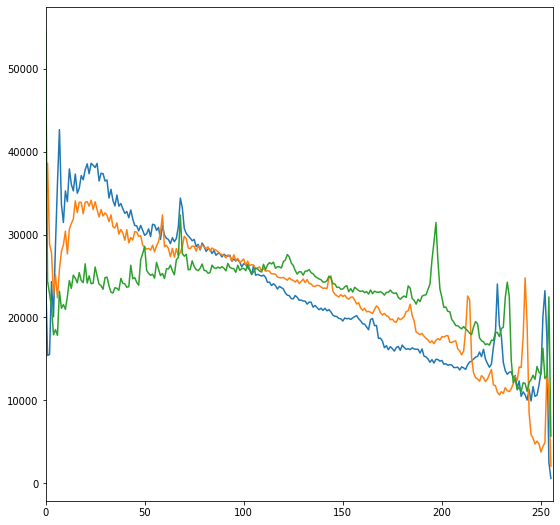

In [90]:
# Histograma de una imagen

import cv2
import numpy as np
from matplotlib import pyplot as plt
  
img = cv2.imread('resultado.png')
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Calculate histogram without mask
hist1 = cv2.calcHist([img],[0],None,[256],[0,256])
hist2 = cv2.calcHist([img],[1],None,[256],[0,256])
hist3 = cv2.calcHist([img],[2],None,[256],[0,256])

plt.figure(figsize=(20,20))
plt.subplot(222), plt.plot(hist1), plt.plot(hist2), plt.plot(hist3)
plt.xlim([0,256])

plt.show()



100%|██████████| 2539/2539 [00:00<00:00, 6276.34it/s]


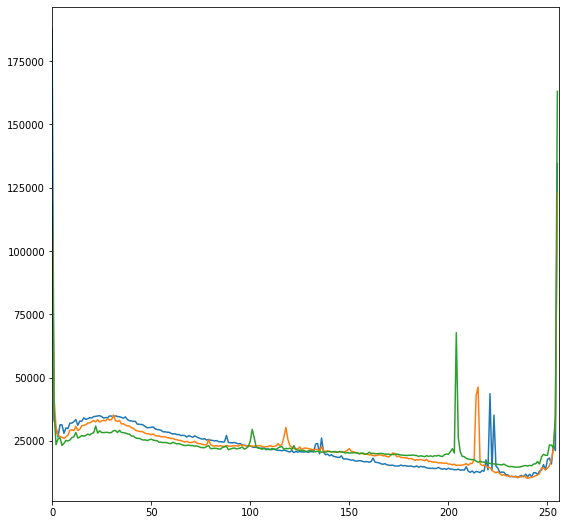

In [99]:
# Histograma de todas las imagenes en una carpeta

import cv2
import numpy as np
from matplotlib import pyplot as plt

n = 0

with tqdm(total=len(glob.glob('imagenes' + r'\\*'))) as pbar:
    for archivo in glob.glob('imagenes' + r'\\*'):
        imagen = cv2.imread(archivo)
        if n == 0:  
            histRT = cv2.calcHist([imagen],[0],None,[256],[0,256])
            histGT = cv2.calcHist([imagen],[1],None,[256],[0,256])
            histBT = cv2.calcHist([imagen],[2],None,[256],[0,256])
        else:
            histR = cv2.calcHist([imagen],[0],None,[256],[0,256])
            histG = cv2.calcHist([imagen],[1],None,[256],[0,256])
            histB = cv2.calcHist([imagen],[2],None,[256],[0,256])
            histRT = np.add(histR,histRT)
            histGT = np.add(histG,histGT)
            histBT = np.add(histB,histBT)
        n = n + 1
        pbar.update(1)
    
plt.figure(figsize=(20,20))
plt.subplot(222), plt.plot(histRT), plt.plot(histGT), plt.plot(histBT)
plt.xlim([0,256])

plt.show()


100%|██████████| 2539/2539 [00:05<00:00, 472.70it/s] 


fotos\001395.jpg


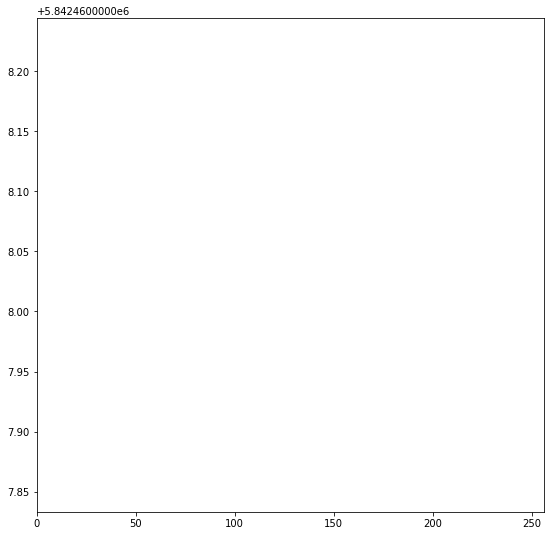

In [113]:
# Comparacion de histogramas

import cv2
import numpy as np
from matplotlib import pyplot as plt

# Genera histograma de imagen base
#img = cv2.imread('resultado.png')

#histU = cv2.calcHist([img],[0],None,[256],[0,256])
#histV = cv2.calcHist([img],[1],None,[256],[0,256])
#histW = cv2.calcHist([img],[2],None,[256],[0,256])

histoBASE = [histRT, histGT, histBT]
histoTEST = {}
histoCERO = [0, 0, 0]
# Genera histograma promedio de imagenes en carpeta

id_imagen = ''
n = 0
R = 0
G = 0
B = 0

# los archivos parece que no tienen que tener espacios para que funcione
with tqdm(total = len(glob.glob('fotos' + r'\\*'))) as pbar:
    for archivo in glob.glob('fotos' + r'\\*'):
        imagen = cv2.imread(archivo)

        histX = cv2.calcHist([imagen], [0], None, [256], [0, 256])
        histY = cv2.calcHist([imagen], [1], None, [256], [0, 256])
        histZ = cv2.calcHist([imagen], [2], None, [256], [0, 256])

        R = cv2.compareHist(histRT, histX, cv2.HISTCMP_CHISQR)
        G = cv2.compareHist(histGT, histY, cv2.HISTCMP_CHISQR)
        B = cv2.compareHist(histBT, histZ, cv2.HISTCMP_CHISQR)
        
        histoTEST[n] = [R, G, B]

        if n == 0:
            distancia_guardada = buscar_distancia(histoCERO, histoTEST[n])
        
        else:
        
            distancia_temporal = buscar_distancia(histoCERO, histoTEST[n])

            if distancia_temporal < distancia_guardada:
                distancia_guardada = distancia_temporal
                id_imagen = archivo
        
        n = n + 1   
        
        pbar.update(1)
    
print (id_imagen)

plt.figure(figsize=(20,20))
plt.subplot(222), plt.plot(R), plt.plot(G), plt.plot(B)
plt.xlim([0,256])

plt.show()

In [112]:
cv2.calcHist([imagen], [0], None, [256], [0, 256])

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],

# Coso que elige pixeles random cuando hay mucho del mismo color

In [ ]:
# Guarda los indices para las mejores coincidencias
# Loop through each pixel in the low-res reference image and find the index of the image that has the closest mean colour.<br>
# **The 'match' variable returns a list of the closest 40 matches and one is randomly chosen - this is to reduce repeat images for similar colours that are close to each other. This number would need to be smaller than the number of images available**

image_idx = np.zeros(target_res, dtype=np.uint32)

for i in range(target_res[0]):
    for j in range(target_res[1]):

        template = mos_template[i, j]

        match = tree.query(template, k=40)
        pick = random.randint(0, 39)
        image_idx[i, j] = match[1][pick]
